# Load simulated data

In [1]:
import numpy as np
import torch
from sbi.utils import BoxUniform

from teddy.data.Alphabet import Alphabet
from teddy.data.dataset import MsaLabels

lower_bound = torch.as_tensor([1.0, 1.0])
upper_bound = torch.as_tensor([5.0, 10.0])
prior = BoxUniform(low=lower_bound, high=upper_bound)

alphabet = Alphabet(["A", "C", "G", "T"])

In [6]:
def observe(clock_rate):
    simulations = MsaLabels(f"data/clock_rate-{clock_rate}/seq", alphabet)

    theta_0 = torch.Tensor(simulations[0][1])
    x_0 = torch.flatten(torch.Tensor(simulations[0][0][0]))

    return theta_0, x_0

def load_data(clock_rate):
    simulations = MsaLabels(f"data/clock_rate-{clock_rate}/seq", alphabet)
    
    theta, x = [], []

    for index, simulation in enumerate(simulations):
        if index == 0:
            continue
        theta.append(simulation[1])
        x.append(simulation[0][0])

    theta = torch.Tensor(np.array(theta))
    x = torch.Tensor(np.array(x))

    print(f"Data for clock rate 1e-{clock_rate} loaded.")

    return theta, x

# Summary statistics

In [15]:
def extract_dates_vector(x):
    dates = x[:,1:,:1]
    return dates

def compute_asd_matrix(x):
    sequences = x[1:,2:]
    seq_nb, seq_length = len(sequences), len(sequences[0])
    asd = [[0 for _ in range(seq_nb)] for _ in range(seq_nb)]
    for seq1 in range(seq_nb):
        for seq2 in range(seq_nb):
            for locus in range(seq_length):
                if sequences[seq1,locus] != sequences[seq2,locus]:
                    asd[seq1][seq2] += 1
    return torch.Tensor(asd)

def summarize(x):
    data = []
    for sim in x:
        dates = extract_dates_vector(sim)
        asd = compute_asd_matrix(sim)
        data.append(torch.cat(torch.flatten(dates), torch.flatten(asd)))
    return torch.Tensor(data)

# NPE training

In [3]:
from sbi.inference import NPE
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding

In [ ]:
def train_npe(clock_rate, embedding=False):
    if embedding:
        embedding_net = FCEmbedding(
            input_dim=50702,
            output_dim=10,
            num_layers=2,
            num_hiddens=50
        )
        density_estimator = posterior_nn(model="maf", embedding_net=embedding_net)
        npe = NPE(prior=prior, density_estimator=density_estimator)
    else:
        npe = NPE(prior=prior)
    
    theta, x = load_data(clock_rate)
    x = torch.flatten(x, start_dim=1)
    npe.append_simulations(theta, x)
    npe.train()

    print(f"NPE for clock rate 1e-{clock_rate} trained.")

    posterior = npe.build_posterior()
    return posterior

def sample_npe(clock_rate, sample_size=10_000, embedding=False):
    _, x_0 = observe(clock_rate)
    posterior = train_npe(clock_rate, embedding)
    samples = posterior.sample((sample_size,), x=x_0)
    print(f"Posterior for clock rate 1e-{clock_rate} sampled.")
    return samples

# NPE plotting

In [5]:
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

In [6]:
def plot_npe(clock_rate, sample_size=1_000, embedding=False):
    theta_0, _ = observe(clock_rate)
    samples = sample_npe(clock_rate, sample_size, embedding)

    fig, axes = pairplot(
        samples,
        labels=["Basic reproduction number", "Infectious time"],
        figsize=(8, 8),
        points=theta_0,
        points_colors="r",
    )
    plt.suptitle(f"NPE Posterior (clock rate: 1e-{clock_rate})", y=1.02)
    plt.show()

def compare_embedding(clock_rate, sample_size=1_000):
    theta_0, _ = observe(clock_rate)
    no_emb_samples = sample_npe(clock_rate, sample_size, embedding=False)
    emb_samples = sample_npe(clock_rate, sample_size, embedding=True)

    fig, axes = pairplot(
        [no_emb_samples, emb_samples],
        labels=["Basic reproduction number", "Infectious time"],
        figsize=(8, 8),
        points=theta_0,
        points_colors="r",
        diag="hist",
        upper="scatter",
    )
    fig.legend(
        ["No embedding", "Embedding"],
        loc="upper right",
        bbox_to_anchor=(0.95, 0.95),
    )
    plt.suptitle("NPE Posterior Comparison (effect of embedding)", y=1.02, fontsize=14)
    plt.show()

def compare_npe(clock_rates, sample_size=1_000, embedding=False):
    theta_0, _ = observe(0)

    samples, labels = [], []
    for clock_rate in clock_rates:
        samples.append(sample_npe(clock_rate, sample_size, embedding))
        labels.append(f"1e-{clock_rate}")
    
    fig, axes = pairplot(
        samples,
        labels=["Basic reproduction number", "Infectious time"],
        figsize=(8, 8),
        points=theta_0,
        points_colors="r",
        diag="hist",
        upper="scatter",
    )
    fig.legend(
        labels,
        loc="upper right",
        bbox_to_anchor=(0.95, 0.95),
    )
    plt.suptitle("NPE Posterior Comparison (various clock rates)", y=1.02, fontsize=14)
    plt.show()

# Sandbox

Data for clock rate 1e-0 loaded.
 Neural network successfully converged after 32 epochs.NPE for clock rate 1e-0 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-0 sampled.


/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_99008/2564892087.py:5: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


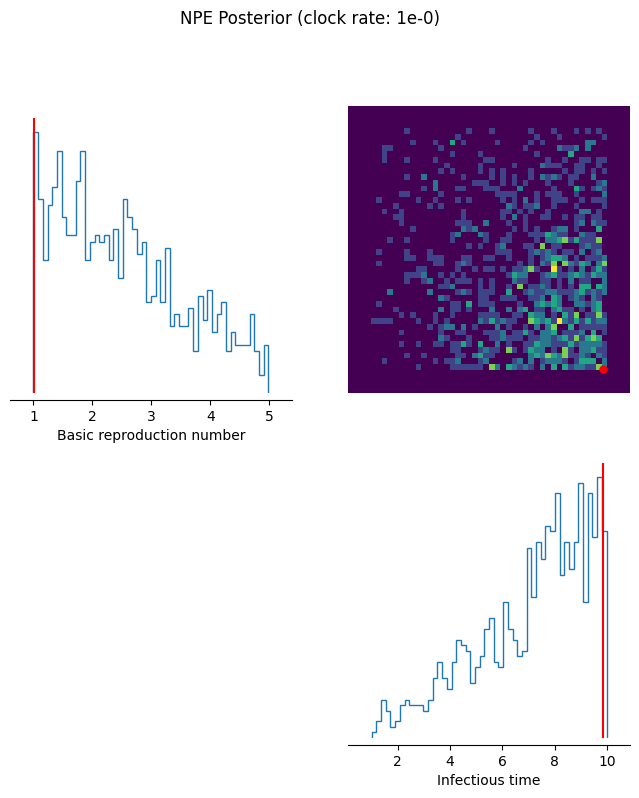

In [7]:
plot_npe(0)

Data for clock rate 1e-0 loaded.
 Neural network successfully converged after 30 epochs.NPE for clock rate 1e-0 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-0 sampled.
Data for clock rate 1e-0 loaded.
 Neural network successfully converged after 26 epochs.NPE for clock rate 1e-0 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-0 sampled.


/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_99008/2564892087.py:20: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


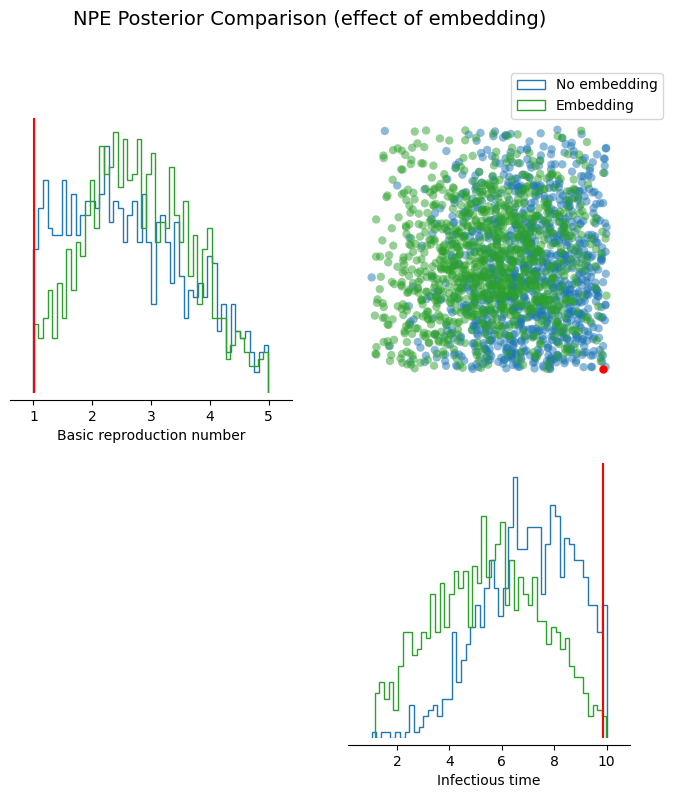

In [8]:
compare_embedding(0)

Data for clock rate 1e-6 loaded.
 Neural network successfully converged after 28 epochs.NPE for clock rate 1e-6 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-6 sampled.
Data for clock rate 1e-4 loaded.
 Neural network successfully converged after 28 epochs.NPE for clock rate 1e-4 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-4 sampled.
Data for clock rate 1e-2 loaded.
 Neural network successfully converged after 28 epochs.NPE for clock rate 1e-2 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-2 sampled.
Data for clock rate 1e-0 loaded.
 Neural network successfully converged after 29 epochs.NPE for clock rate 1e-0 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-0 sampled.


/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_99008/2564892087.py:45: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


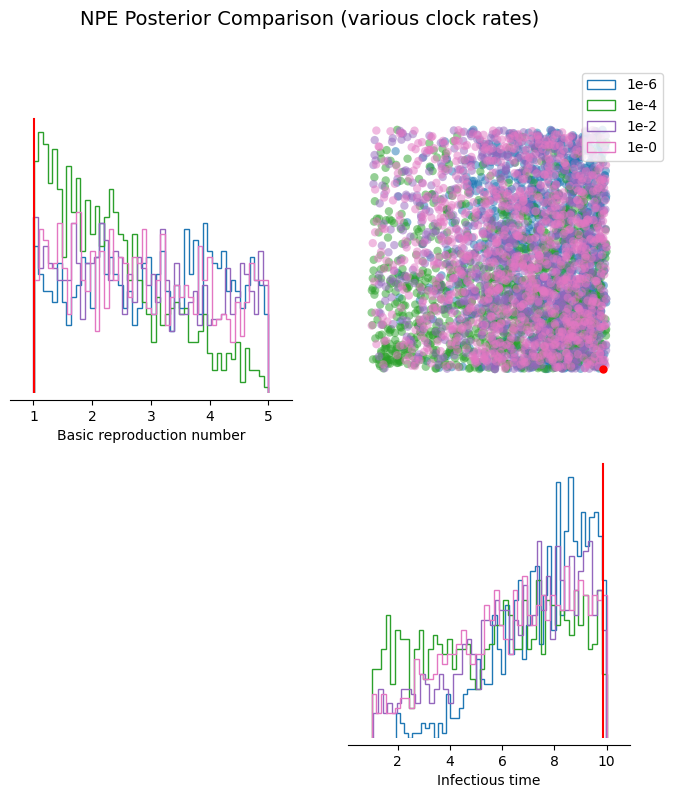

In [9]:
compare_npe([6, 4, 2, 0])

Data for clock rate 1e-6 loaded.
 Neural network successfully converged after 28 epochs.NPE for clock rate 1e-6 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-6 sampled.
Data for clock rate 1e-4 loaded.
 Neural network successfully converged after 25 epochs.NPE for clock rate 1e-4 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-4 sampled.
Data for clock rate 1e-2 loaded.
 Neural network successfully converged after 30 epochs.NPE for clock rate 1e-2 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-2 sampled.
Data for clock rate 1e-0 loaded.
 Neural network successfully converged after 25 epochs.NPE for clock rate 1e-0 trained.


  0%|          | 0/1000 [00:00<?, ?it/s]

Posterior for clock rate 1e-0 sampled.


/var/folders/tj/j43hbx0j0jvcmz6tvdtf2v0c0000gn/T/ipykernel_99008/2564892087.py:45: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


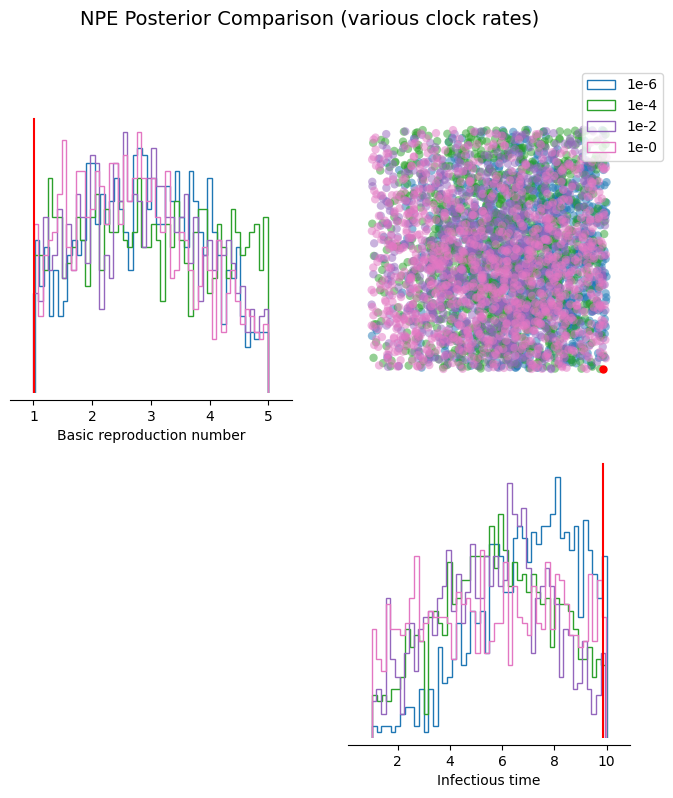

In [ ]:
compare_npe([6, 4, 2, 0], embedding=True)